## StarGalaxy_Hierarchical Demo

### Example 1: Run one simulated image
#### Generate a test image, extract sources and image cutouts with SourceExtractor and then fit them.

First things first - compile the C code.

In [1]:
import code_builder
code_builder.ffibuilder.compile(verbose=True)

generating ./_fitter.c
(already up-to-date)
the current directory is '/data/tmp/stargalaxy_hierarchical'
running build_ext
building '_fitter' extension
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.5m -I/data/tmp/stargalaxy_hierarchical/stargalaxy/include/python3.5m -c _fitter.c -o ./_fitter.o
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./_fitter.o -lm -o ./_fitter.cpython-35m-x86_64-linux-gnu.so


'/data/tmp/stargalaxy_hierarchical/_fitter.cpython-35m-x86_64-linux-gnu.so'

Some further setup...

In [2]:
import numpy as np
import gen_cutouts
import fitter
import astropy.io.fits as pyfits
import gen_field
import multiprocessing as mp
import pandas
import os

# some integer value to add to temporary file names and change random seeds
xid = 1

# generate temporary file names
im = 'im_%d.fits' % xid
var = 'var_%d.fits' % xid
slist = 'slist_%d.fits' % xid
psf_name = 'psf_%d.fits' % xid

# generate some random background and seeing values
S0 = np.random.get_state()
np.random.seed(xid)
bg = 10**np.random.uniform(1.5, 2.5)
see = np.random.uniform(0.6, 1.7)
np.random.set_state(S0)

# set pixel scale
scale = 0.3


Now generate the test image and variance arrays, source list, psf and save them to disk. By default the star fraction is 0.6, there are 4096 pixels and 40 sources (40^2 sources total) per axis.

In [3]:
_ = gen_field.gen_field(plot_image=False, save_to_fits=True, seed=xid,
                    variance_fname=var, source_list_fname=slist,
                    image_fname=im, psf_fname=psf_name,
                    background_level=bg, seeing=see, pixel_scale=scale)

Display the test image for illustrative purposes. Highlighted sources are 'stellar', else sources on the regular grid are 'galaxies'.

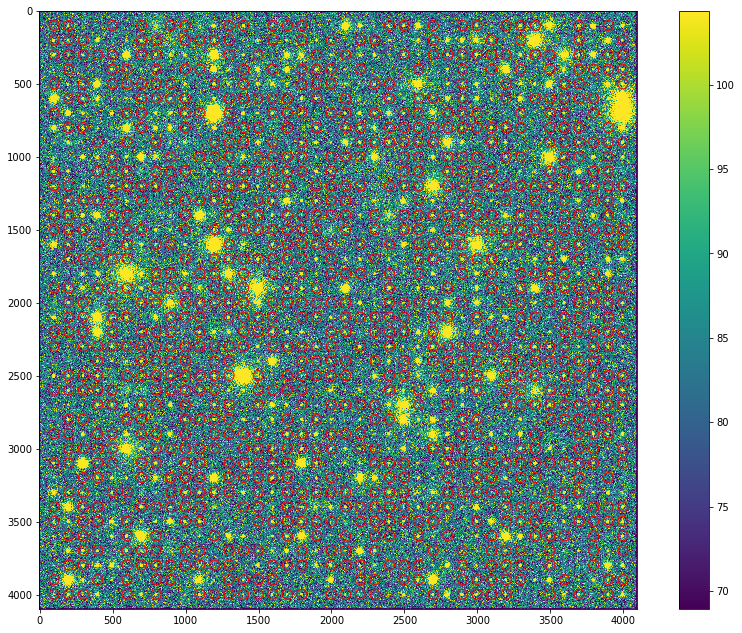

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the image
detector_array = pyfits.getdata(im, -1, view=np.array)
fig = plt.figure(figsize=(15, 11))
minmax = np.percentile(detector_array, [5, 95])
plt.imshow(detector_array, vmin=minmax[0], vmax=minmax[1])
plt.colorbar()

# load the source list
source_list = pyfits.getdata(slist, -1, view=np.recarray)
# identify stars (no sersic index)
star = np.isnan(source_list['n'])
# plot the galaxies
#plt.scatter(source_list["X"][~star], source_list["Y"][~star], marker='+', c='red', label='G')
# and the stars
plt.scatter(source_list["X"][star], source_list["Y"][star], s=100, facecolors='none', edgecolors='r', label='Star')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=2)

Display the psf for illustrative purposes.

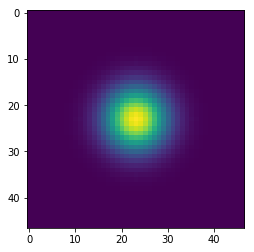

In [5]:
psf = pyfits.getdata(psf_name)
fig = plt.figure()
plt.imshow(psf)

Now extract sources and image cutouts using Source Extractor. It's safe (albeit ugly) to ignore Source Extractor's complaint. If Source Extractor detects a source that was not in the original source list it will throw a warning, a couple of these we can ignore for now.

In [6]:
R = gen_cutouts.run(im, var, slist)

Ouch, SExtractor complains :
b''


{'CATALOG_TYPE': 'FITS_1.0', 'CHECKIMAGE_TYPE': 'SEGMENTATION,BACKGROUND', 'WEIGHT_TYPE': 'MAP_VAR', 'CHECKIMAGE_NAME': './tmpaoql53g5/segm_temp_9552.fits,./tmpaoql53g5/bg_temp_9552.fits', 'PHOT_APERTURES': '5.000000', 'WEIGHT_IMAGE': 'var_1.fits'}


/data/tmp/stargalaxy_hierarchical/gen_cutouts.py:81: UserWarning: This source doesn't appear to correspond to real source
  "This source doesn't appear to correspond to real source")


Generate the sersic and point source model grid

In [7]:
# sersic radius and index grid parameters
# these are the defaults but we'll define them here so we can use them later on
minr = 0.1 # min
maxr = 25 # max
nr = 21 # and number of radius steps
minn = 0.5 # min
maxn = 5 # max
nn = 20 # and number of sersic index steps

# now generate the grid
grid = fitter.gengrid(pixel_scale=scale, minr=minr, maxr=maxr, nr=nr, minn=minn, maxn=maxn, nn=nn)

Load the psf model (in case it wasn't loaded in the earlier illustrative step), and set a uniform prior across the galaxy models for demonstrative purposes.

In [8]:
psf = pyfits.getdata(psf_name)
lprior = np.zeros(len(grid))-np.log(len(grid))

Now convolve the models with the psf and fit to the extracted image cutouts.

In [9]:
XR = fitter.fitextractions(grid, lprior, R, psf, get_grid=True, benchmark=True)

159.40ms per source


Produce some output in a more useful form

In [10]:
fluxes0 = np.array([_['flux'] for _ in R])
star0 = np.array([_['star0'] for _ in R])
fap = np.array([_['FLUX_APER'] for _ in R])
nobj = len(R)
xdict = {'flux0': fluxes0, 'star0':star0, 'FLUX_APER':fap,'bg':bg+np.zeros(nobj), 'seeing':see +np.zeros(nobj)}
xdict['logl_s']=np.array(XR[0]).flatten()
xdict['logl_g']=np.array(XR[1]).tolist()
df = pandas.DataFrame(xdict)

Now perform the hierarchical inference given the log-likelihoods

In [11]:
%%capture --no-stderr
pstar, pgals = fitter.dohierarch(df['logl_s'], np.vstack(df['logl_g']))

pstar is the stellar fraction. If the fitter is behaving this should come out approximately the same as the input value, in this case 0.6.

In [12]:
print("%.3f" % pstar)

0.598


pgals is a pdf array over the galaxy models, when run on real images this is a measure of the hyper-prior. We'll just plot the pdf for now for illustration.

Text(0, 0.5, 'n')

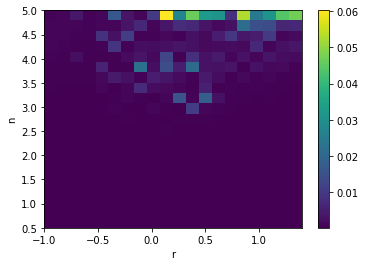

In [13]:
plt.figure()
plt.imshow(pgals.reshape(nr,nn), origin='lower', 
           extent=[np.log10(minr),np.log10(maxr),minn,maxn], 
           aspect=0.45)
plt.colorbar()
plt.xlabel("r")
plt.ylabel("n")

On our generated images it looks fairly unphysical (the input Sersic index distribution stops at 4!), perhaps this is unsurprising. We are exploring several possible reasons for this - blending and/or centroiding are the primary suspects. Another problem here is lack of data - we have ~1k sources and we need many times that to have a meaningful output.